<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/Improved_MLP(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# ======================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# ======================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Step 1: Libraries imported successfully!")
print("TensorFlow version:", tf.__version__)


Step 1: Libraries imported successfully!
TensorFlow version: 2.18.0


In [12]:

# ======================================================================
# STEP 2: LOAD AND PREPARE DATA
# ======================================================================

print("\nStep 2: Loading and preparing data...")

# Load datasets
try:
    train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')
    print(f"✓ Data loaded successfully!")
    print(f"  - Train shape: {train_df.shape}")
    print(f"  - Validation shape: {val_df.shape}")
    print(f"  - Test shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"✗ Error loading files: {e}")
    print("Please ensure train.csv, validation.csv, and test.csv are in the working directory")



Step 2: Loading and preparing data...
✓ Data loaded successfully!
  - Train shape: (3584, 84)
  - Validation shape: (768, 84)
  - Test shape: (768, 84)


In [13]:

# ======================================================================
# STEP 3: HANDLE MISSING VALUES
# ======================================================================

print(f"\nStep 3: Checking and handling missing values...")
print(f"Missing values:")
print(f"  - Train: {train_df.isnull().sum().sum()}")
print(f"  - Validation: {val_df.isnull().sum().sum()}")
print(f"  - Test: {test_df.isnull().sum().sum()}")

# Handle missing values if any
if train_df.isnull().sum().sum() > 0:
    train_df = train_df.fillna(train_df.median(numeric_only=True))
    val_df = val_df.fillna(val_df.median(numeric_only=True))
    test_df = test_df.fillna(test_df.median(numeric_only=True))
    print("✓ Missing values handled with median imputation")
else:
    print("✓ No missing values found")



Step 3: Checking and handling missing values...
Missing values:
  - Train: 0
  - Validation: 0
  - Test: 0
✓ No missing values found


In [14]:

# ======================================================================
# STEP 4: CREATE 3-CLASS LABELS BASED ON PRODUCTION QUANTILES
# ======================================================================

print(f"\nStep 4: Creating 3-class labels...")

# Combine all data to calculate quantiles consistently across all datasets
all_data = pd.concat([train_df, val_df, test_df], ignore_index=True)
production_col = 'Production (M.Ton)'

# Calculate quantiles for 3 classes (33.33% and 66.67% percentiles)
quantiles = all_data[production_col].quantile([0.3333, 0.6667]).values
print(f"Quantile thresholds:")
print(f"  - Low to Medium: {quantiles[0]:.4f}")
print(f"  - Medium to High: {quantiles[1]:.4f}")

def create_production_labels(production_values):
    """Create 3-class labels based on quantiles"""
    labels = []
    for val in production_values:
        if val <= quantiles[0]:
            labels.append('low')
        elif val <= quantiles[1]:
            labels.append('medium')
        else:
            labels.append('high')
    return labels

# Apply labels to each dataset
train_df['production_label'] = create_production_labels(train_df[production_col])
val_df['production_label'] = create_production_labels(val_df[production_col])
test_df['production_label'] = create_production_labels(test_df[production_col])

print(f"\nClass distribution:")
print("Training set:")
train_dist = train_df['production_label'].value_counts().sort_index()
for label, count in train_dist.items():
    print(f"  - {label}: {count} ({count/len(train_df)*100:.1f}%)")

print("Validation set:")
val_dist = val_df['production_label'].value_counts().sort_index()
for label, count in val_dist.items():
    print(f"  - {label}: {count} ({count/len(val_df)*100:.1f}%)")

print("Test set:")
test_dist = test_df['production_label'].value_counts().sort_index()
for label, count in test_dist.items():
    print(f"  - {label}: {count} ({count/len(test_df)*100:.1f}%)")



Step 4: Creating 3-class labels...
Quantile thresholds:
  - Low to Medium: 1068.8158
  - Medium to High: 3901.8373

Class distribution:
Training set:
  - high: 1199 (33.5%)
  - low: 1198 (33.4%)
  - medium: 1187 (33.1%)
Validation set:
  - high: 257 (33.5%)
  - low: 253 (32.9%)
  - medium: 258 (33.6%)
Test set:
  - high: 251 (32.7%)
  - low: 256 (33.3%)
  - medium: 261 (34.0%)


In [15]:

# ======================================================================
# STEP 5: SEPARATE FEATURES AND ENCODE LABELS
# ======================================================================

print(f"\nStep 5: Separating features and encoding labels...")

# Separate features and labels
feature_cols = [col for col in train_df.columns if col not in [production_col, 'production_label']]
print(f"Number of features: {len(feature_cols)}")

X_train = train_df[feature_cols].values
X_val = val_df[feature_cols].values
X_test = test_df[feature_cols].values

# Encode labels (ensure consistent encoding across all datasets)
label_encoder = LabelEncoder()
all_labels = np.concatenate([train_df['production_label'], val_df['production_label'], test_df['production_label']])
label_encoder.fit(all_labels)

y_train = label_encoder.transform(train_df['production_label'])
y_val = label_encoder.transform(val_df['production_label'])
y_test = label_encoder.transform(test_df['production_label'])

# Convert to categorical for neural network
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"✓ Data preparation completed!")
print(f"  - Feature shape: {X_train.shape[1]}")
print(f"  - Number of classes: {num_classes}")
print(f"  - Classes: {list(label_encoder.classes_)}")



Step 5: Separating features and encoding labels...
Number of features: 83
✓ Data preparation completed!
  - Feature shape: 83
  - Number of classes: 3
  - Classes: ['high', 'low', 'medium']


In [16]:

# ======================================================================
# STEP 6: STANDARDIZE FEATURES
# ======================================================================

print("\nStep 6: Standardizing features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Data standardization completed!")
print(f"  - Training set scaled shape: {X_train_scaled.shape}")
print(f"  - Validation set scaled shape: {X_val_scaled.shape}")
print(f"  - Test set scaled shape: {X_test_scaled.shape}")



Step 6: Standardizing features...
✓ Data standardization completed!
  - Training set scaled shape: (3584, 83)
  - Validation set scaled shape: (768, 83)
  - Test set scaled shape: (768, 83)


In [17]:

# ======================================================================
# STEP 7: BUILD IMPROVED MLP MODEL
# ======================================================================

print(f"\nStep 7: Building improved MLP model...")

dropout_rate = 0.4
input_shape = X_train_scaled.shape[1]

print(f"  - Input features: {input_shape}")
print(f"  - Output classes: {num_classes}")
print(f"  - Dropout rate: {dropout_rate}")

model = Sequential()

# Input layer with more units
model.add(Dense(512, input_shape=(input_shape,), name='input_layer'))
model.add(BatchNormalization(name='bn_1'))
model.add(tf.keras.layers.Activation('gelu', name='gelu_1'))  # GELU activation
model.add(Dropout(dropout_rate, name='dropout_1'))

# Hidden layer 1
model.add(Dense(256, name='hidden_1'))
model.add(BatchNormalization(name='bn_2'))
model.add(tf.keras.layers.Activation('gelu', name='gelu_2'))
model.add(Dropout(dropout_rate, name='dropout_2'))

# Hidden layer 2
model.add(Dense(128, name='hidden_2'))
model.add(BatchNormalization(name='bn_3'))
model.add(tf.keras.layers.Activation('gelu', name='gelu_3'))
model.add(Dropout(dropout_rate, name='dropout_3'))

# Hidden layer 3
model.add(Dense(64, name='hidden_3'))
model.add(BatchNormalization(name='bn_4'))
model.add(tf.keras.layers.Activation('gelu', name='gelu_4'))
model.add(Dropout(dropout_rate * 0.8, name='dropout_4'))  # Slightly reduced dropout

# Hidden layer 4
model.add(Dense(32, name='hidden_4'))
model.add(BatchNormalization(name='bn_5'))
model.add(tf.keras.layers.Activation('gelu', name='gelu_5'))
model.add(Dropout(dropout_rate * 0.6, name='dropout_5'))  # Further reduced dropout

# Output layer
model.add(Dense(num_classes, activation='softmax', name='output_layer'))

# Compile model with Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model architecture created!")
print("\nModel Summary:")
model.summary()

# Count trainable parameters
try:
    trainable_params = model.count_params()
    print(f"\nTotal trainable parameters: {trainable_params:,}")
except:
    print("\nParameter count not available")



Step 7: Building improved MLP model...
  - Input features: 83
  - Output classes: 3
  - Dropout rate: 0.4
✓ Model architecture created!

Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 512)            │        43,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gelu_1 (Activation)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gelu_2 (Activation)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gelu_3 (Activation)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gelu_4 (Activation)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_5 (BatchNormalization)       │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gelu_5 (Activation)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,635 (865.76 KB)

 Trainable params: 219,651 (858.01 KB)

 Non-trainable params: 1,984 (7.75 KB)


Total trainable parameters: 221,635


In [18]:

# ======================================================================
# STEP 8: TRAIN THE MODEL
# ======================================================================

print(f"\nStep 8: Training model...")

epochs = 100
batch_size = 64

print(f"  - Epochs: {epochs}")
print(f"  - Batch size: {batch_size}")

# Define callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Train model
print("Starting training...")
history = model.fit(
    X_train_scaled, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_scaled, y_val_cat),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("✓ Training completed!")
print(f"  - Total epochs run: {len(history.history['loss'])}")
print(f"  - Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  - Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")



Step 8: Training model...
  - Epochs: 100
  - Batch size: 64
Starting training...
Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.3500 - loss: 1.2382 - val_accuracy: 0.6276 - val_loss: 0.9980 - learning_rate: 0.0010
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4949 - loss: 1.0158 - val_accuracy: 0.7031 - val_loss: 0.7725 - learning_rate: 0.0010
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6095 - loss: 0.8340 - val_accuracy: 0.7266 - val_loss: 0.6182 - learning_rate: 0.0010
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6881 - loss: 0.7192 - val_accuracy: 0.7708 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7355 - loss: 0.6350 - val_accuracy: 0.7917 - val_loss: 0.4981 - learning_rate: 0.0010
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7676 - loss: 0.5764 - val_accuracy: 0.8164 - val_loss: 0.4428 - learning_rate: 0.0010
Epoch

In [19]:

# ======================================================================
# STEP 9: MAKE PREDICTIONS
# ======================================================================

print("\nStep 9: Making predictions...")

# Validation predictions
y_val_pred_probs = model.predict(X_val_scaled, verbose=0)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Test predictions
y_test_pred_probs = model.predict(X_test_scaled, verbose=0)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

print("✓ Predictions completed!")



Step 9: Making predictions...
✓ Predictions completed!


In [20]:

# ======================================================================
# STEP 10: CALCULATE COMPREHENSIVE METRICS
# ======================================================================

def calculate_comprehensive_metrics(y_true, y_pred, label_encoder, dataset_name):
    """Calculate all required metrics"""

    accuracy = accuracy_score(y_true, y_pred)

    # Precision scores
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)

    # Recall scores
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)

    metrics = {
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Macro)': recall_macro,
        'Recall (Weighted)': recall_weighted,
        'F1 Score (Macro)': f1_macro,
        'F1 Score (Weighted)': f1_weighted
    }

    # Print detailed results
    print(f"\n{'='*60}")
    print(f"{dataset_name.upper()} SET RESULTS")
    print(f"{'='*60}")

    for metric, value in metrics.items():
        print(f"{metric:<25}: {value:.4f}")

    # Per-class metrics
    print(f"\nPer-class metrics:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"{class_name.capitalize():<10} - Precision: {precision_per_class[i]:.4f}, "
              f"Recall: {recall_per_class[i]:.4f}, F1: {f1_per_class[i]:.4f}")

    return metrics

print("\nStep 10: Calculating comprehensive metrics...")

# Calculate metrics for validation and test sets
val_metrics = calculate_comprehensive_metrics(y_val, y_val_pred, label_encoder, "Validation")
test_metrics = calculate_comprehensive_metrics(y_test, y_test_pred, label_encoder, "Test")



Step 10: Calculating comprehensive metrics...

VALIDATION SET RESULTS
Accuracy                 : 0.9023
Precision (Macro)        : 0.9044
Precision (Weighted)     : 0.9040
Recall (Macro)           : 0.9025
Recall (Weighted)        : 0.9023
F1 Score (Macro)         : 0.9032
F1 Score (Weighted)      : 0.9029

Per-class metrics:
High       - Precision: 0.8897, Recall: 0.9105, F1: 0.9000
Low        - Precision: 0.9751, Recall: 0.9289, F1: 0.9514
Medium     - Precision: 0.8485, Recall: 0.8682, F1: 0.8582

TEST SET RESULTS
Accuracy                 : 0.9102
Precision (Macro)        : 0.9122
Precision (Weighted)     : 0.9118
Recall (Macro)           : 0.9103
Recall (Weighted)        : 0.9102
F1 Score (Macro)         : 0.9110
F1 Score (Weighted)      : 0.9107

Per-class metrics:
High       - Precision: 0.9197, Recall: 0.9124, F1: 0.9160
Low        - Precision: 0.9634, Recall: 0.9258, F1: 0.9442
Medium     - Precision: 0.8535, Recall: 0.8927, F1: 0.8727



Step 11: Plotting training history...


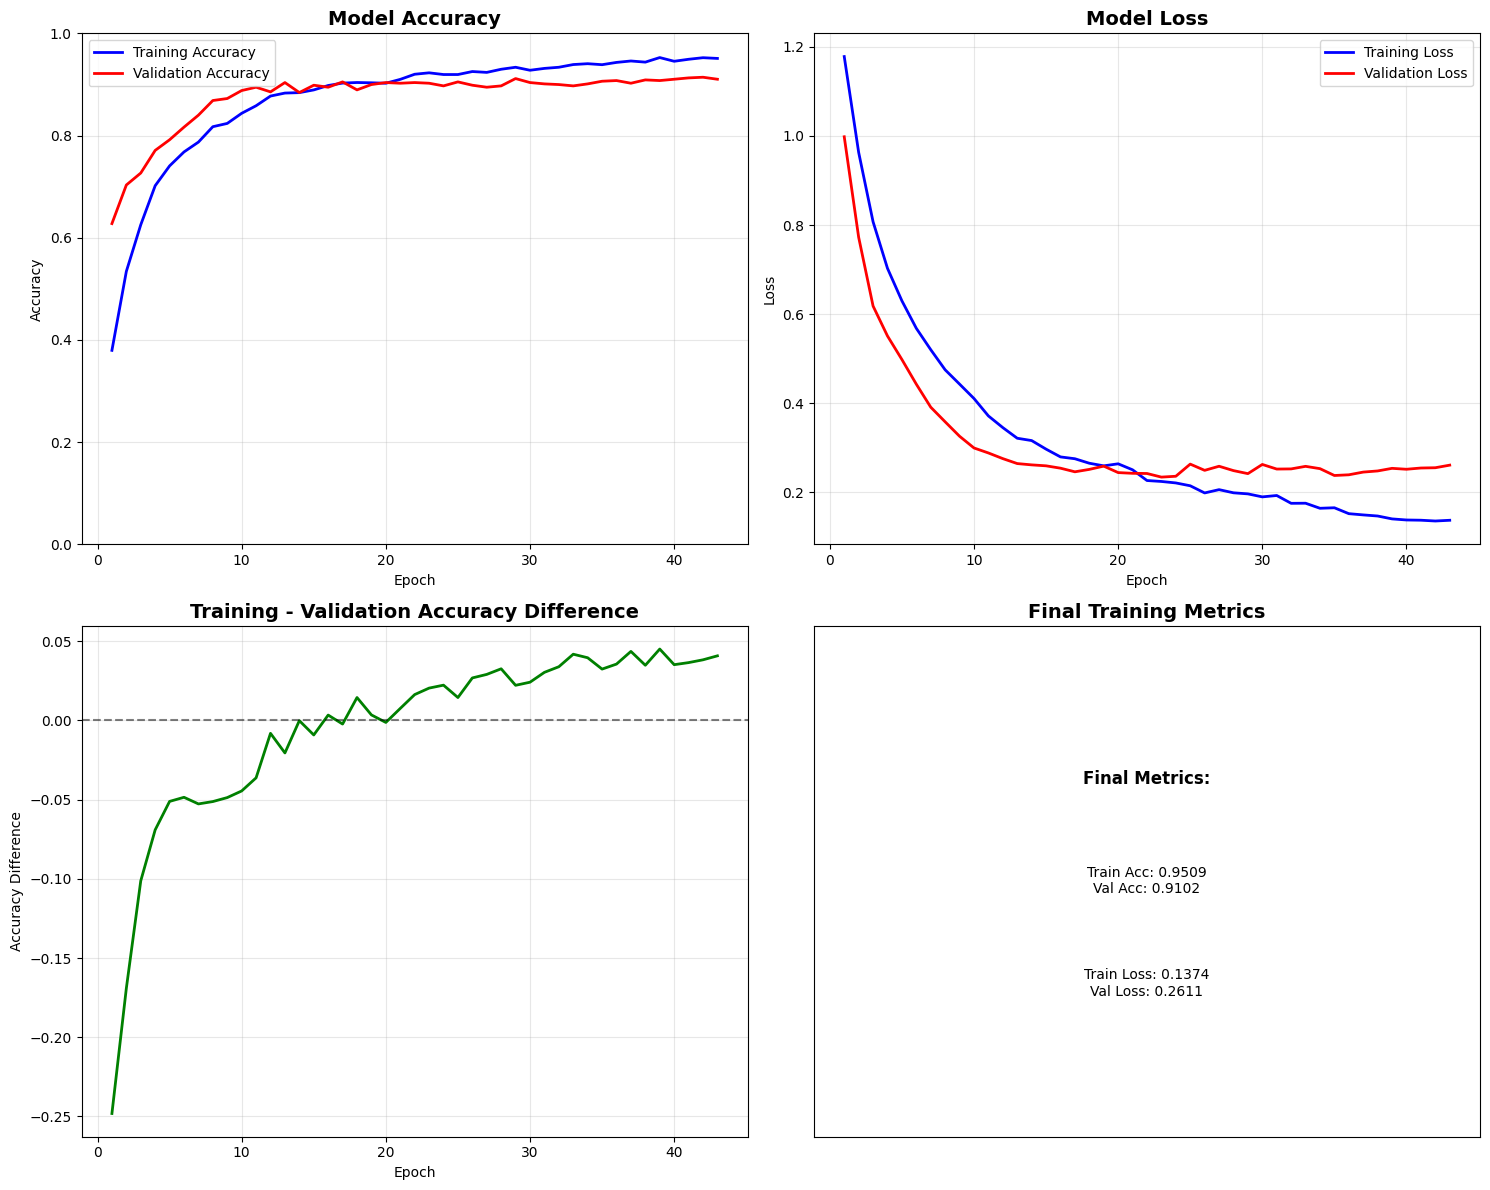

In [21]:

# ======================================================================
# STEP 11: PLOT TRAINING HISTORY
# ======================================================================

def plot_training_history(history):
    """Plot training and validation metrics"""

    print("\nStep 11: Plotting training history...")

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    epochs_range = range(1, len(history.history['accuracy']) + 1)

    # Plot accuracy
    ax1.plot(epochs_range, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs_range, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Plot loss
    ax2.plot(epochs_range, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    ax2.plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot accuracy difference
    acc_diff = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
    ax3.plot(epochs_range, acc_diff, 'g-', linewidth=2)
    ax3.set_title('Training - Validation Accuracy Difference', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy Difference')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)

    # Plot learning rate (if available)
    if 'lr' in history.history:
        ax4.plot(epochs_range, history.history['lr'], 'purple', linewidth=2)
        ax4.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Learning Rate')
        ax4.set_yscale('log')
        ax4.grid(True, alpha=0.3)
    else:
        # Show final metrics instead
        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]

        ax4.text(0.5, 0.7, f'Final Metrics:', ha='center', va='center',
                transform=ax4.transAxes, fontsize=12, fontweight='bold')
        ax4.text(0.5, 0.5, f'Train Acc: {final_train_acc:.4f}\nVal Acc: {final_val_acc:.4f}',
                ha='center', va='center', transform=ax4.transAxes, fontsize=10)
        ax4.text(0.5, 0.3, f'Train Loss: {final_train_loss:.4f}\nVal Loss: {final_val_loss:.4f}',
                ha='center', va='center', transform=ax4.transAxes, fontsize=10)
        ax4.set_title('Final Training Metrics', fontsize=14, fontweight='bold')
        ax4.set_xticks([])
        ax4.set_yticks([])

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)



Step 12: Generating confusion matrices...


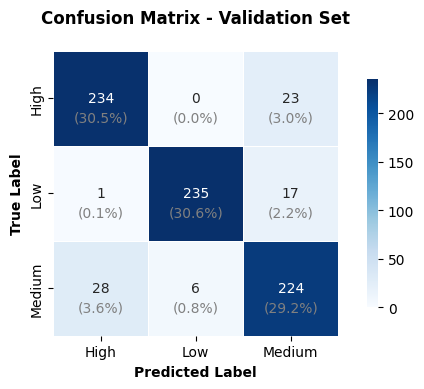

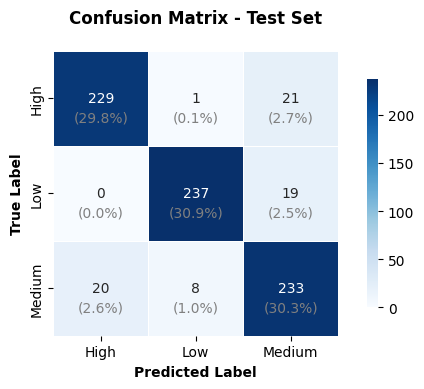

In [22]:

# ======================================================================
# STEP 12: PLOT CONFUSION MATRICES
# ======================================================================

def plot_confusion_matrix(y_true, y_pred, label_encoder, dataset_name):
    """Plot confusion matrix with better styling"""

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[name.capitalize() for name in label_encoder.classes_],
                yticklabels=[name.capitalize() for name in label_encoder.classes_],
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})

    plt.title(f'Confusion Matrix - {dataset_name} Set', fontsize=12, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=10, fontweight='bold')
    plt.ylabel('True Label', fontsize=10, fontweight='bold')

    # Add percentage annotations
    total = cm.sum()
    for i in range(len(label_encoder.classes_)):
        for j in range(len(label_encoder.classes_)):
            percentage = cm[i, j] / total * 100
            plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                    ha='center', va='center', fontsize=10, color='gray')

    plt.tight_layout()
    plt.show()

print("\nStep 12: Generating confusion matrices...")

# Plot confusion matrices
plot_confusion_matrix(y_val, y_val_pred, label_encoder, "Validation")
plot_confusion_matrix(y_test, y_test_pred, label_encoder, "Test")



Step 13: Plotting performance comparison...


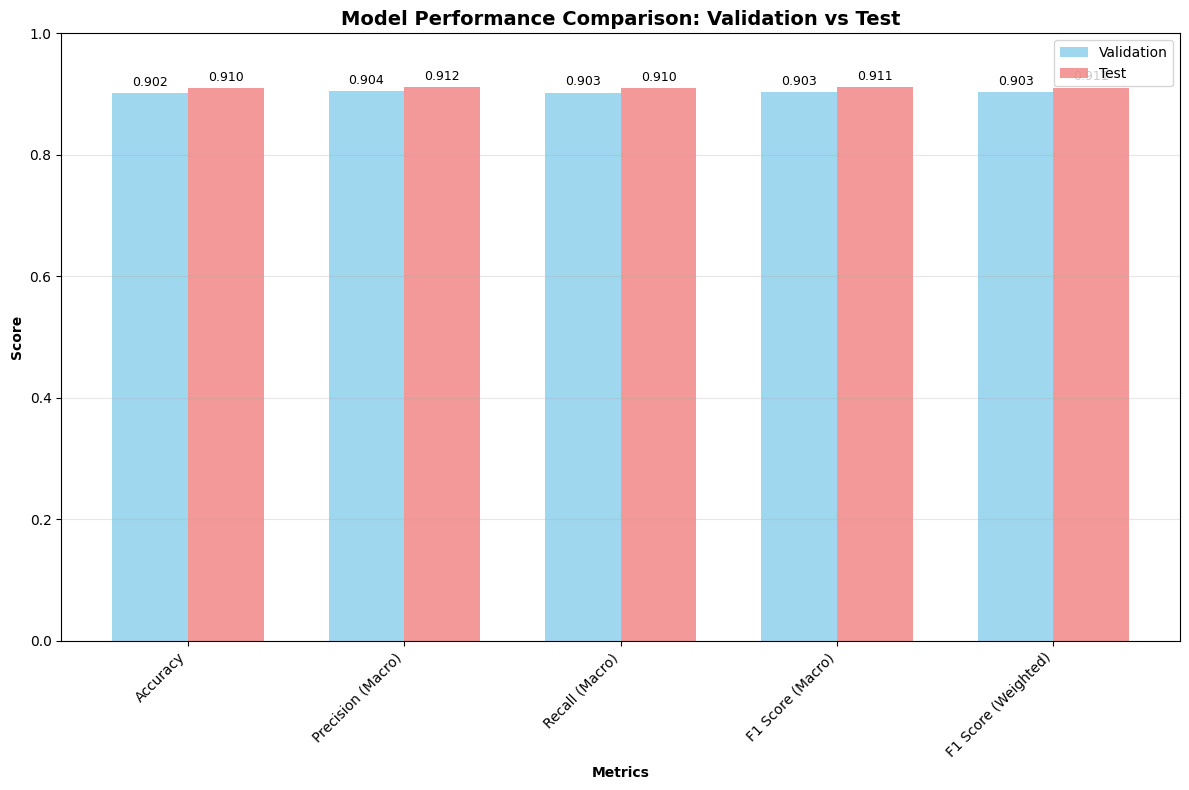

In [23]:

# ======================================================================
# STEP 13: PLOT PERFORMANCE COMPARISON
# ======================================================================

def plot_model_performance_comparison(val_metrics, test_metrics):
    """Plot comparison between validation and test metrics"""

    metrics_names = ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)', 'F1 Score (Weighted)']
    val_values = [val_metrics[metric] for metric in metrics_names]
    test_values = [test_metrics[metric] for metric in metrics_names]

    x = np.arange(len(metrics_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))
    bars1 = ax.bar(x - width/2, val_values, width, label='Validation', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, test_values, width, label='Test', alpha=0.8, color='lightcoral')

    ax.set_xlabel('Metrics', fontweight='bold')
    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title('Model Performance Comparison: Validation vs Test', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

print("\nStep 13: Plotting performance comparison...")

# Plot performance comparison
plot_model_performance_comparison(val_metrics, test_metrics)


In [24]:

# ======================================================================
# STEP 14: DETAILED CLASSIFICATION REPORTS
# ======================================================================

print("\nStep 14: Generating detailed classification reports...")

# Detailed classification reports
print(f"\n{'='*80}")
print("DETAILED CLASSIFICATION REPORT - VALIDATION SET")
print(f"{'='*80}")
print(classification_report(y_val, y_val_pred,
                          target_names=[name.capitalize() for name in label_encoder.classes_],
                          digits=4))

print(f"\n{'='*80}")
print("DETAILED CLASSIFICATION REPORT - TEST SET")
print(f"{'='*80}")
print(classification_report(y_test, y_test_pred,
                          target_names=[name.capitalize() for name in label_encoder.classes_],
                          digits=4))



Step 14: Generating detailed classification reports...

DETAILED CLASSIFICATION REPORT - VALIDATION SET
              precision    recall  f1-score   support

        High     0.8897    0.9105    0.9000       257
         Low     0.9751    0.9289    0.9514       253
      Medium     0.8485    0.8682    0.8582       258

    accuracy                         0.9023       768
   macro avg     0.9044    0.9025    0.9032       768
weighted avg     0.9040    0.9023    0.9029       768


DETAILED CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

        High     0.9197    0.9124    0.9160       251
         Low     0.9634    0.9258    0.9442       256
      Medium     0.8535    0.8927    0.8727       261

    accuracy                         0.9102       768
   macro avg     0.9122    0.9103    0.9110       768
weighted avg     0.9118    0.9102    0.9107       768



In [25]:

# ======================================================================
# STEP 15: FINAL PERFORMANCE SUMMARY
# ======================================================================

print("\nStep 15: Final performance summary...")

# Final summary
print(f"\n{'='*80}")
print("🎯 FINAL PERFORMANCE SUMMARY")
print(f"{'='*80}")
print(f"{'Metric':<25} {'Validation':<12} {'Test':<12} {'Difference':<12}")
print("-" * 65)

key_metrics = ['Accuracy', 'F1 Score (Macro)', 'F1 Score (Weighted)']
for metric in key_metrics:
    val_score = val_metrics[metric]
    test_score = test_metrics[metric]
    diff = abs(val_score - test_score)
    print(f"{metric:<25} {val_score:<12.4f} {test_score:<12.4f} {diff:<12.4f}")

# Model generalization assessment
macro_f1_diff = abs(val_metrics['F1 Score (Macro)'] - test_metrics['F1 Score (Macro)'])
if macro_f1_diff < 0.05:
    generalization = "Excellent"
elif macro_f1_diff < 0.10:
    generalization = "Good"
elif macro_f1_diff < 0.15:
    generalization = "Fair"
else:
    generalization = "Poor"

print(f"\n🔍 Model Generalization Assessment: {generalization}")
print(f"   Macro F1 Score Difference: {macro_f1_diff:.4f}")

print("\n✅ Pipeline execution completed successfully!")
print("💾 Model and results are ready for use.")


Step 15: Final performance summary...

🎯 FINAL PERFORMANCE SUMMARY
Metric                    Validation   Test         Difference  
-----------------------------------------------------------------
Accuracy                  0.9023       0.9102       0.0078      
F1 Score (Macro)          0.9032       0.9110       0.0077      
F1 Score (Weighted)       0.9029       0.9107       0.0078      

🔍 Model Generalization Assessment: Excellent
   Macro F1 Score Difference: 0.0077

✅ Pipeline execution completed successfully!
💾 Model and results are ready for use.
